In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

import konlpy
from konlpy.tag import Okt
from konlpy.tag import Mecab

okt = Okt()
mecab = Mecab()

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 8.2 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2024-12-22 07:46:15--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 13.200.41.136, 13.200.41.135, 13.200.41.134, ...
Connecting to bitbucket.org (bitbucket.org)|13.200.41.136|:443... connected.
HTTP request sent, await

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 가져오기
review = pd.read_csv('/content/drive/MyDrive/labeling_data1.csv', encoding='utf-8')

# 중복 제거
review.drop_duplicates(subset=['title'], inplace=True)

# NULL 값 제거
review = review.dropna(how='any')

# 한글, 공백, 숫자(특수문자 사이에 있는 숫자는 제거) 제외하고 모두 제거
review['title'] = review['title'].apply(lambda x: re.sub(r'(?<=\W)\d+(?=\W)|[^\wㄱ-ㅎㅏ-ㅣ가-힣\s]', "", x))

print(review['title'])

0                    키스타임사직야구장 롯데자이언츠응원 shortsvideo 롯데자이언츠
1                                      이제 외국에서 한국말 함부로 못해요
2             1000만뷰1박2일 내내 쏟아지는 폭우 속 우중캠핑  새 화로대 개시했어요   
3        1000만뷰하루종일 비 내리는 날 경차로 여름휴가 떠나기  개별화장실 계곡 앞 신생...
4                                 도저히 못 들어갈 갠지스강 바닥에 쌓인 것들
                               ...                        
14554                      눈 내리는 궁궐   어디일까요    마음에 들면 두번터치
14555     외국인 여자친구 만나러 2개월만에 태국 방콕으로 국제커플 International...
14556                             아직도 이해하기 힘든 일본버스 요금정산 방식
14557    캠핑카세계여행 캠핑장으로 가는 길들이 다 막혀버렸다  영국에서 캠핑장 찾아 삼만리 ...
14558    아름다운 폭포와 계곡이 있는 동해시 무릉계곡 추천해드립니다 여기는 올 여름에 꼭 다...
Name: title, Length: 13538, dtype: object


In [ ]:
# POS 태깅
def tokenize_and_pos_tagging(text):
    if not isinstance(text, str):
        return []

    # 예외 단어 리스트
    exceptions = [
        '동남아', '여사친', '호캉스', '관종', '천원', '오랜만', '갬성', '고기',
        '도미토리', '가성비', '마피랭패스', '로바다야키', '방센비치', '코시창',
        '이케시마', '극강', '엘칼라파테', '엘찰텐', '푸에르토', '나탈레스',
        '아카타마', '우유니', '잔지바르', '마데이라', '몬테네그로', '푸바오'
    ]

    # 예외 단어를 먼저 찾아 'Noun'으로 태깅
    exceptions_pattern = '|'.join(map(re.escape, exceptions))
    matches = re.finditer(exceptions_pattern, text)

    result = []
    last_index = 0

    for match in matches:
        # 예외 단어 이전의 텍스트를 분석
        if match.start() > last_index:
            result.extend(okt.pos(text[last_index:match.start()]))

        # 예외 단어 태깅
        result.append((match.group(), 'Noun'))
        last_index = match.end()

    # 남은 텍스트 분석
    if last_index < len(text):
        result.extend(okt.pos(text[last_index:]))

    return result

# 필요한 품사(명사, 동사, 형용사, 숫자, 부사)를 제외한 나머지 품사들은 삭제
def extract(pos_tags):
  return [word for word, tag in pos_tags if tag in ['Noun','Verb','Adjective','Number','Adverb']]

# POS 태깅 적용
review['title'] = review['title'].apply(tokenize_and_pos_tagging)

print(review['title'][74])

# 불필요한 품사 제거
review['title'] = review['title'].apply(extract)

review = review[review['title'].apply(len) > 0].reset_index(drop=True)

print(review['title'])

[('시골', 'Noun'), ('에서', 'Josa'), ('미혼', 'Noun'), ('여자', 'Noun'), ('혼자', 'Noun'), ('살', 'Noun'), ('면', 'Josa'), ('생기는', 'Verb'), ('일', 'Noun')]
0                    [키스타임, 사직야구장, 롯데, 자이언츠, 응원, 롯데, 자이언츠]
1                                   [이제, 외국, 한국말, 함부로, 해요]
2        [1000만, 1, 박, 2일, 내내, 쏟아지는, 폭우, 속, 우중, 캠핑, 새, ...
3        [1000만, 비, 내리는, 날, 경차, 여름, 휴가, 떠나기, 개별, 화장실, 계...
4                           [도저히, 못, 들어갈, 갠지스강, 바닥, 쌓인, 것]
                               ...                        
13529               [눈, 내리는, 궁궐, 어디, 일까, 요, 마음, 들면, 번, 터치]
13530              [외국인, 여자친구, 만나러, 2, 개월, 태국, 방콕, 국제, 커플]
13531                   [아직도, 이해, 하기, 힘든, 일본, 버스, 금정산, 방식]
13532    [캠핑카, 세계, 여행, 캠핑장, 가는, 길들이, 다, 막혀, 버렸다, 영국, 캠핑...
13533    [아름다운, 폭포, 계곡, 있는, 동해시, 무릉, 계곡, 추천, 해드립니다, 여기는...
Name: title, Length: 13534, dtype: object


In [ ]:
df = pd.DataFrame(review)

df.to_csv('/content/drive/MyDrive/real_data_okt.csv', index=False)

## CNN

In [ ]:
from gensim.models import Word2Vec# kor2vec 모델 학습

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Flatten,Dropout,Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
sentences = review['title'].tolist() #리뷰에서 추출한 형용사와 동사 토큰 리스트
word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg = 0)

#각 단어를 Word2Vec 벡터로 변환하는 함수 정의
def get_word_index(word,model):
  if word in model.wv:
    return model.wv.key_to_index[word]+1 # Keras Embedding 레이어는 인덱스가 1부터 시작해야함
  return 0 # 없는 단어는 0으로 패딩

#각 리뷰를 정수 인덱스 시퀀스로 변환
review['vectorized_review'] = review['title'].apply(lambda tokens: [get_word_index(word,word2vec_model) for word in tokens])


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 38)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 38, 100)        │      1,704,800 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 38, 100, 1)     │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 36, 1, 128)     │         38,528 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 18, 1, 128)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subscriber_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 2304)           │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │             64 │ subscriber_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 2336)           │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        299,136 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 6)              │            774 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,043,302 (7.79 MB)

 Trainable params: 338,502 (1.29 MB)

 Non-trainable params: 1,704,800 (6.50 MB)

Epoch 1/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.2976 - loss: 1.4097 - val_accuracy: 0.4100 - val_loss: 1.2246
Epoch 2/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4107 - loss: 1.2270 - val_accuracy: 0.4274 - val_loss: 1.2196
Epoch 3/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4184 - loss: 1.2191 - val_accuracy: 0.4363 - val_loss: 1.1922
Epoch 4/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4248 - loss: 1.2042 - val_accuracy: 0.4274 - val_loss: 1.1833
Epoch 5/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4396 - loss: 1.1879 - val_accuracy: 0.4281 - val_loss: 1.1904
Epoch 6/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4274 - loss: 1.1942 - val_accuracy: 0.4352 - val_loss: 1.1868
Epoch 7/30
677/677 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4363 - loss: 1.1836 - val_accuracy: 0.4315 - val_loss: 1.1852
Test Loss: 1.1833258867263794
Test Accuracy: 0.42741042375564575


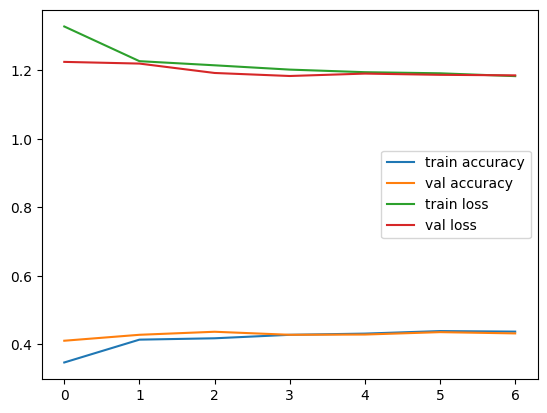

In [ ]:
# 구독자수 데이터 정규화 (0~1 사이 값으로 스케일링)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
review['normalized_subscribers'] = scaler.fit_transform(review['subscribers'].values.reshape(-1, 1))  # 구독자수 컬럼이 있다고 가정

# 각 리뷰를 문장을 벡터로 변환(단어 임베딩)
max_len = 38  # 각 리뷰의 최대 길이(단어 수)

# 패딩 처리하여 모든 리뷰의 길이를 동일하게 맞춤
X_text = pad_sequences(review['vectorized_review'], maxlen=max_len)

# 구독자수 데이터를 별도 변수로 저장
X_subscribers = review['normalized_subscribers'].values

# 라벨 데이터 준비
y = review['label']

# 학습 데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, X_sub_train, X_sub_test, y_train, y_test = train_test_split(
    X_text, X_subscribers, y, test_size=0.2, random_state=42
)

# 라벨 데이터를 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=6)
y_test_one_hot = to_categorical(y_test, num_classes=6)

# 사전 학습된 Word2Vec 임베딩 행렬 생성
vocab_size = len(word2vec_model.wv) + 1  # 단어 집합 크기 (+1은 패딩 공간)
embedding_dim = word2vec_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word2vec_model.wv.key_to_index.items():
    embedding_matrix[i] = word2vec_model.wv[word]  # 인덱스는 1부터 시작

# CNN 모델 구성
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding, Reshape, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)

# 텍스트 입력 처리
text_input = Input(shape=(max_len,), name='text_input')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(text_input)
reshape_layer = Reshape((max_len, embedding_dim, 1))(embedding_layer)
conv_layer = Conv2D(filters=128, kernel_size=(3, embedding_dim), padding='valid', activation='relu')(reshape_layer)
pooling_layer = MaxPooling2D(pool_size=(2, 1))(conv_layer)
flatten_layer = Flatten()(pooling_layer)

# 구독자수 입력 처리
subscriber_input = Input(shape=(1,), name='subscriber_input')
subscriber_dense = Dense(32, activation='relu')(subscriber_input)

# 텍스트와 구독자수 특징 결합
concat_layer = Concatenate()([flatten_layer, subscriber_dense])

# Fully Connected Layer
fc_layer = Dense(128, activation='relu')(concat_layer)
dropout_layer = Dropout(0.5)(fc_layer)

# Output Layer
output_layer = Dense(6, activation='softmax')(dropout_layer)

# 모델 정의
model = Model(inputs=[text_input, subscriber_input], outputs=output_layer)

# 모델 컴파일
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 모델 요약
model.summary()

# EarlyStopping 콜백 추가
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
batch_size = 16
epochs = 30

history = model.fit(
    [X_text_train, X_sub_train], y_train_one_hot,
    batch_size=batch_size, epochs=epochs,
    validation_data=([X_text_test, X_sub_test], y_test_one_hot),
    callbacks=[early_stopping], verbose=1
)

# 모델 평가
score = model.evaluate([X_text_test, X_sub_test], y_test_one_hot, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

# 훈련 과정 시각화
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
# 새로운 텍스트 데이터와 구독자수
new_text = ["축제 즐기러 가는 일본 여행"]
new_subscribers = [100000]  # 예: 10만 구독자

# 1. 텍스트 데이터 전처리
def preprocess_text(text):
    # 1.1 POS 태깅 및 불필요한 품사 제거
    pos_tags = tokenize_and_pos_tagging(text)
    filtered_tokens = extract(pos_tags)
    # 1.2 Word2Vec 임베딩 인덱스로 변환
    vectorized_text = [get_word_index(word, word2vec_model) for word in filtered_tokens]
    return vectorized_text

# 새 텍스트 데이터 전처리
new_text_vectorized = [preprocess_text(text) for text in new_text]

# 2. 패딩 처리
new_text_padded = pad_sequences(new_text_vectorized, maxlen=max_len)

# 3. 구독자수 정규화
new_subscribers_normalized = scaler.transform(np.array(new_subscribers).reshape(-1, 1))

# 4. 모델 예측
predictions = model.predict([new_text_padded, new_subscribers_normalized])

# 예측 결과 출력
predicted_labels = np.argmax(predictions, axis=1)  # 가장 높은 확률의 클래스
print("예측된 라벨:", predicted_labels)
print("클래스별 확률 분포:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
예측된 라벨: [0]
클래스별 확률 분포: [[0.2857497  0.259018   0.22050808 0.1040905  0.08401432 0.04661936]]


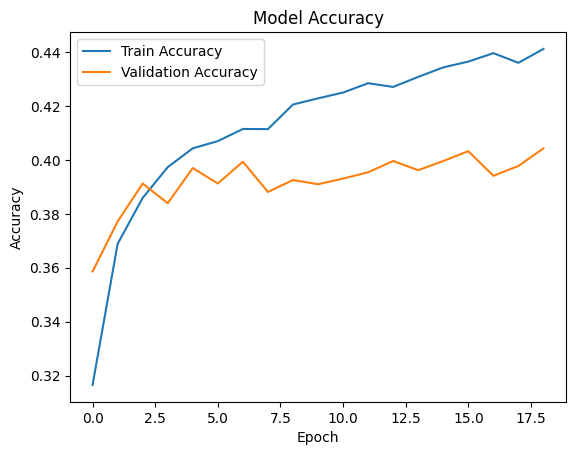

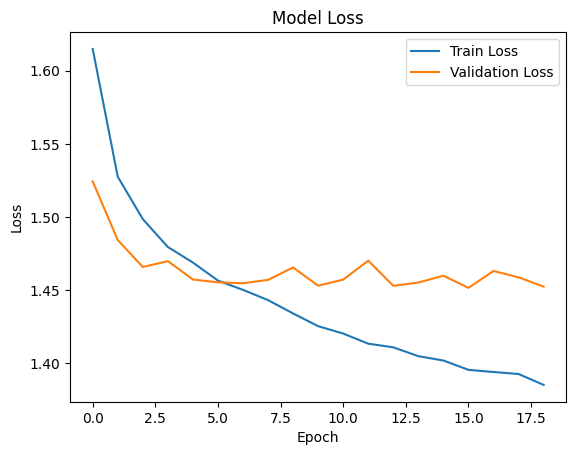

In [ ]:
import matplotlib.pyplot as plt

# 학습 정확도 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.53      0.66      0.59       772
           1       0.32      0.29      0.30       810
           2       0.29      0.35      0.31       658
           3       0.24      0.02      0.04       423
           4       0.31      0.47      0.37       609
           5       0.72      0.50      0.59       562

    accuracy                           0.40      3834
   macro avg       0.40      0.38      0.37      3834
weighted avg       0.40      0.40      0.39      3834



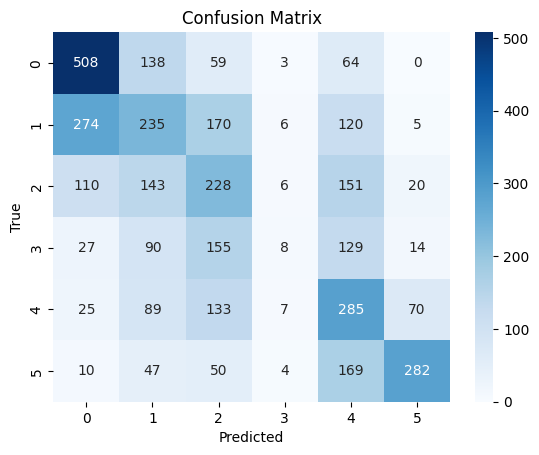

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
X_sub_test = X_sub_test.reshape(-1, 1)  # (3934, 1) 형태로 변환

# 테스트 데이터 예측
y_pred = np.argmax(model.predict([X_text_test, X_sub_test]), axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# 분류 보고서 출력
print(classification_report(y_true, y_pred))

# 혼동 행렬 시각화
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


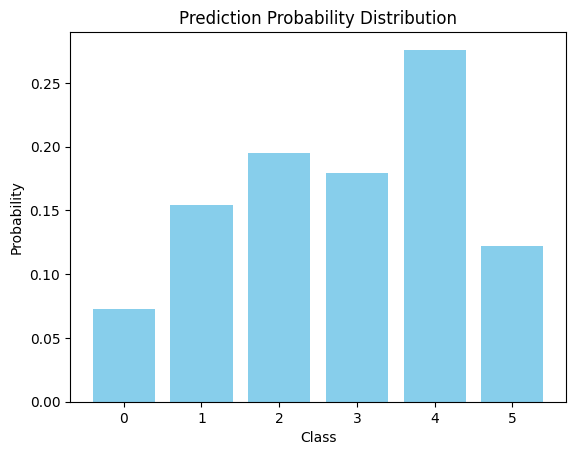

In [ ]:
# 새 데이터 예측
predictions = model.predict([new_text_padded, new_subscribers_normalized])

# 확률 분포 시각화
plt.bar(range(6), predictions[0], color='skyblue')
plt.title('Prediction Probability Distribution')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(range(6))
plt.show()


In [ ]:
# idx에 해당하는 'title' 확인
print(review['title'].iloc[0])  # 예시로 첫 번째 리뷰 확인
print(type(review['title'].iloc[0]))  # 형식 확인


['이', '선정', '한국', '가장', '아름다운', '섬', '선재도', '목섬', '바다', '갈라짐', '11월', '국내', '여행지', '추천', '인천', '여행', '옹진군', '섬', '여행', '국내', '여행', '추천', '섬', '여행', '가볼만', '곳']
<class 'list'>


Number of correct words: 17279


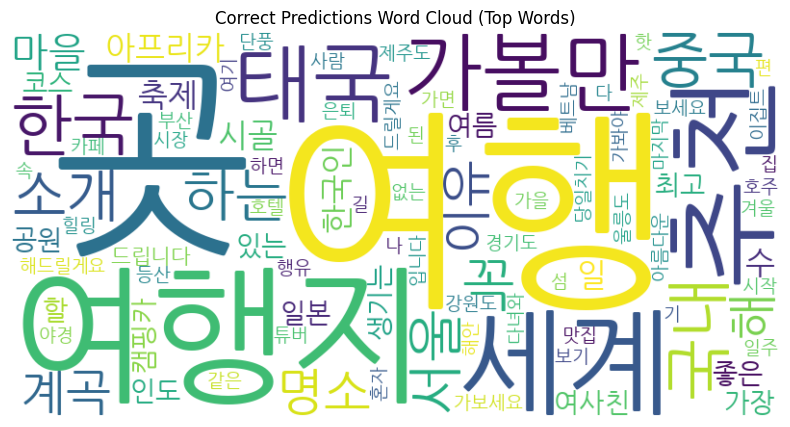

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 경로 설정
font_path = "/content/drive/MyDrive/NanumGothic.ttf"  # 시스템에 설치된 한글 폰트 경로

# 상위 N개의 단어만 추출하도록 설정
TOP_N = 100  # 워드클라우드에 포함할 상위 단어 수

# 잘 예측한 데이터와 잘못 예측한 데이터 분리
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# 리스트 형태에서 단어만 추출하는 함수
def extract_words_from_list(text):
    # 'text'는 단어 리스트 형태
    if isinstance(text, list):
        return text  # 리스트 자체를 반환
    return []  # 비정상 데이터는 빈 리스트로 반환

# 단어 빈도수 계산 함수
def get_top_n_words(words, top_n=TOP_N):
    word_counts = Counter(words)
    return " ".join([word for word, _ in word_counts.most_common(top_n)])

# 잘 예측한 데이터에서 중요한 단어 시각화
correct_words = []
for idx in correct_indices:
    # 'review['title'].iloc[idx]'는 단어 리스트 형태이므로 그대로 단어들만 추출
    words = extract_words_from_list(review['title'].iloc[idx])
    if words:  # 유효한 단어가 있을 경우만 추가
        correct_words.extend(words)

# 상위 N개의 단어만 추출
correct_words_str = get_top_n_words(correct_words)
print(f"Number of correct words: {len(correct_words)}")  # 디버깅용 출력

if correct_words_str.strip():
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    ).generate(correct_words_str)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Correct Predictions Word Cloud (Top Words)")
    plt.show()
else:
    print("No words available for Correct Predictions Word Cloud")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


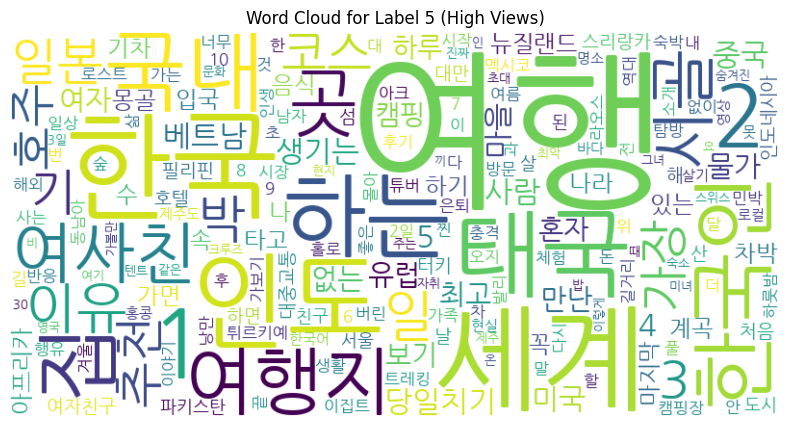

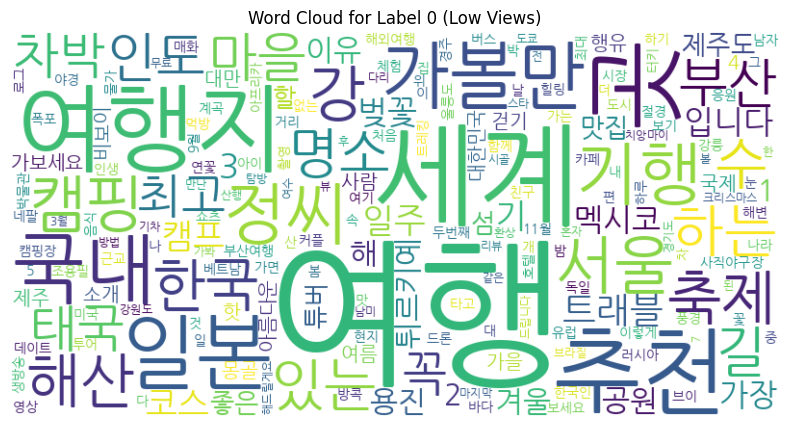

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 한글 폰트 경로 설정
font_path = "/content/drive/MyDrive/NanumGothic.ttf"  # 한글 폰트 경로

# 데이터프레임에서 라벨별 데이터 추출
label_5_data = review[review['label'] == 5]['title']
label_0_data = review[review['label'] == 0]['title']

# 단어 빈도 계산 함수
def calculate_word_frequencies(text_data):
    vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
    word_counts = vectorizer.fit_transform(text_data)
    word_frequencies = word_counts.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    return dict(zip(words, word_frequencies))

# 라벨 5와 라벨 0의 단어 빈도 계산
label_5_frequencies = calculate_word_frequencies(label_5_data)
label_0_frequencies = calculate_word_frequencies(label_0_data)

# 워드 클라우드 생성 함수
def generate_wordcloud(word_frequencies, title):
    wordcloud = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# 라벨 5의 워드 클라우드
generate_wordcloud(label_5_frequencies, "Word Cloud for Label 5 (High Views)")

# 라벨 0의 워드 클라우드
generate_wordcloud(label_0_frequencies, "Word Cloud for Label 0 (Low Views)")


<ipython-input-17-122699b7b6cc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Predicted Label', y='Subscribers', data=results_df, palette='Set2')


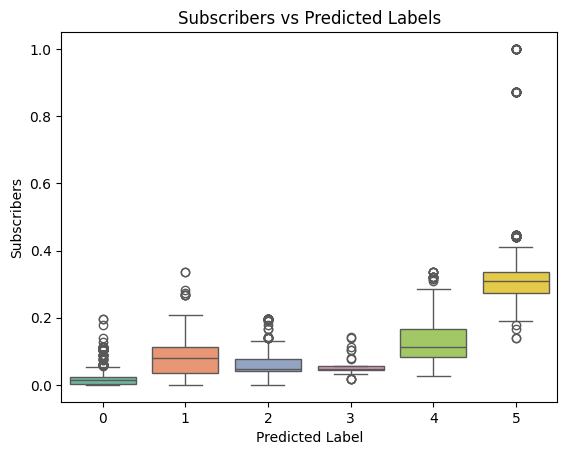

In [ ]:
# 예측된 라벨과 구독자수를 하나의 데이터프레임으로 결합
import pandas as pd

results_df = pd.DataFrame({
    'Subscribers': X_sub_test.flatten(),
    'True Label': y_true,
    'Predicted Label': y_pred
})

# 구독자수와 예측 라벨 간의 관계 시각화
sns.boxplot(x='Predicted Label', y='Subscribers', data=results_df, palette='Set2')
plt.title('Subscribers vs Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Subscribers')
plt.show()


In [ ]:
# 2. 각 리뷰를 문장을 벡터로 변환(단어 임베딩)
max_len = 100 # 각 리뷰의 최대 길이(단어 수)

# 패딩 처리하여 모든 리뷰의 길이를 동일하게 맞춤
X = pad_sequences(review['vectorized_review'],maxlen=max_len)

#라벨 데이터 준비
y = review['label']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 3. CNN 모델 정의 및 학습(Yoon Kim 논문 기반)
vocab_size = len(word2vec_model.wv) + 1 # 단어 집합 크기(+1은 패딩을 위한 공간)
embedding_dim = word2vec_model.vector_size

#사전 학습된 Word2Vec 임베딩 행렬 생성
embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word, i in word2vec_model.wv.key_to_index.items():
  embedding_matrix[i] = word2vec_model.wv[word] # 인덱스는 1부터 시작


In [ ]:
embedding_matrix.shape

(21433, 100)

In [ ]:
from tensorflow.keras.utils import to_categorical

# 라벨 데이터를 원-핫 인코딩
y_train_one_hot = to_categorical(y_train, num_classes=6)
y_test_one_hot = to_categorical(y_test, num_classes=6)

# 모델 구성
model = Sequential()

# Embedding 레이어에 사전 학습된 Word2Vec 가중치 적용
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))  # 가중치 고정

# Reshape (Conv2D에 맞는 4차원 텐서로 변환)
model.add(Reshape((max_len, embedding_dim, 1)))  # (samples, height, width, channels)

# Convolutional Layer (필터 크기: (3,100))
model.add(Conv2D(filters=128, kernel_size=(3, embedding_dim), padding='valid', activation='relu'))

# MaxPooling Layer (height 방향 풀링)
model.add(MaxPooling2D(pool_size=(2, 1)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer + Dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer (다중 클래스 분류를 위한 softmax 활성화 함수)
model.add(Dense(6, activation='softmax'))

# 모델 컴파일 (손실 함수: Categorical Crossentropy)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 요약 출력
model.summary()

# 모델 학습
batch_size = 32
epochs = 50

history = model.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test_one_hot), verbose=1)

# 모델 평가
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │       2,143,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,143,300 (8.18 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,143,300 (8.18 MB)

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2199 - loss: 1.7812 - val_accuracy: 0.2567 - val_loss: 1.7219
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2572 - loss: 1.7265 - val_accuracy: 0.2539 - val_loss: 1.7011
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2592 - loss: 1.7095 - val_accuracy: 0.2608 - val_loss: 1.6955
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2702 - loss: 1.6917 - val_accuracy: 0.2672 - val_loss: 1.6780
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2825 - loss: 1.6728 - val_accuracy: 0.2654 - val_loss: 1.6799
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2964 - loss: 1.6626 - val_accuracy: 0.2649 - val_loss: 1.6909
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3072 - loss: 1.6421 - val_accuracy: 0.2753 - val_loss: 1.6662
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3061 - loss: 1.6359 - val_accuracy: 0